# Predicting Video Game Sales

## Notes for cleaning dataset
- 269 dates missing, often for Japanese Releases or Atari 2600 games
- 245 dates added, some games seem to have been cancelled for a platform although there are numbers for sales volume, so it's best to sort them out (by Year_Of_Release == None)
- Many games seem to have been released in Japan only => Should be ignored (JP_Sales == Global_Sales otherwise)
- Some games explicitly stated (jp sales/japan sales/etc.) => merged logically with global title, sometimes strong effect; influence of Japan Sales would be missing for some rows otherwise
- Slightly contradictory information for a few rows merged anyway using max(entry1, entry2)
- "tbd" => None
- Fun Fact: River Raid a top seller!

In [1]:
# TODO: some visualizations "before doing anything"

# TODO: use functions
# TODO: function to find multiple outliers

# TODO: test removing features with low variance (http://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance)
# TODO: test univariate feature selection (http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

# TODO: read: https://www.datacamp.com/community/tutorials/the-importance-of-preprocessing-in-data-science-and-the-machine-learning-pipeline-i-centering-scaling-and-k-nearest-neighbours
# TODO: test standardization (http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
# TODO: test scaling features to a range [0, 1] (http://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) ...
# TODO: ... and Box-Cox-Test (and https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html)
# TODO: scaling data with outliers (http://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers)
# TODO: test imputation of missing values (http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values)

# TODO: check difference with and without adding platform aggregates (check for missing platforms such as 2600)
# TODO: test generating polynomial features (http://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features)
# TODO: get more features: "brand"? merge with IGN data?

# Import libraries necessary for this project
import numpy as np
import pandas as pd
import scipy as sp

import visuals as vs # External file, check re-engineering necessity
import matplotlib.pyplot as plt

# Allows the use of display() for DataFrames
from IPython.display import display

# sklearn stuff
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.linear_model import ElasticNet, LassoLars, Ridge
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor

RANDOM_STATE =  31415
TEST_SIZE    =  0.25

# make pretty
plt.style.use('ggplot')

# Pretty display for notebooks
%matplotlib inline

# Data Schema

## Dataset 1 (Video_Games_Sales_as_at_22_Dec_2016.csv)
This is my main dataset. It will be used to predict video game sales.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| Name            | Name of the game                                              | String    |
| Platform        | Platform                                                      | String    |
| Year_of_Release | Year of release                                               | Numeric   |
| Genre           | Genre                                                         | String    |
| Publisher       | Publisher                                                     | String    |
| NA_Sales        | Game sales in North America (in millions of units)            | Numeric   |
| EU_Sales        | Game sales in the European Union (in millions of units)       | Numeric   |
| JP_Sales        | Game sales in Japan (in millions of units)                    | Numeric   |
| Other_Sales     | Game sales in the rest of the world (in millions of units)    | Numeric   |
| Global_Sales    | Total sales in the world (in millions of units)               | Numeric   |
| Critic_Score    | Aggregate score compiled by Metacritic staff                  | Numeric   |
| Critic_Count    | The number of critics used in coming up with the Critic_score | Numeric   |
| User_Score      | Score by Metacritic's subscribers                             | Numeric   |
| User_Count      | Number of users who gave the user_score                       | Numeric   |
| Developer       | Party responsible for creating the game                       | String    |
| Rating          | The [ESRB](https://www.esrb.org/) ratings                     | String    |

## Dataset 2 (ign.csv)
This is my secondary dataset. It might be used to support the primary dataset, but this would probably require major effort for merging both.

| title           | description                                                   | data type |
|-----------------|---------------------------------------------------------------|-----------|
| ID              | ID                                                            | Numeric   |
| score_phrase    | Game rating as a phrase                                       | String    |
| title           | Name of the game                                              | String    |
| url             | URL to source of data                                         | String    |
| platform        | Platform                                                      | String    |
| score           | Game rating as a float                                        | Numeric   |
| genre           | Genre                                                         | String    |
| editors_choice  | Special recommendation of the editor                          | String    |
| release_year    | Year of release                                               | Numeric   |
| release_month   | Month of release                                              | Numeric   |
| release_day     | Day of release                                                | Numeric   |


We can remove several colums in dataset2 that we don't need:
* **ID** which is just an ID that's not used in dataset 1
* **score_phrase**, because it redundant to _score_ and less precise
* **url**, because that's just the origin of the data
* **release_month**, too much detail
* **release_day**, too much detail
The next step will be to load the datasets.

In [2]:
def loadDatasets(cleaned = True):
    """Load all necessary datasets"""
    # Load dataset #1
    if (cleaned):
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016_cleaned.csv")
            display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
    else:
        try:
            dataset1 = pd.read_csv("data/Video_Games_Sales_as_at_22_Dec_2016.csv")
            display("Dataset #1 has {} samples with {} possible features.".format(*dataset1.shape))
        except:
            display("Dataset #1 could not be loaded. Is the dataset missing?")
        
    # Load dataset #2
    try:
        dataset2 = pd.read_csv("data/ign.csv")
        display("Dataset #2 has {} samples with {} possible features.".format(*dataset2.shape))
    except:
        display("Dataset #2 could not be loaded. Is the dataset missing?")

    return dataset1, dataset2

In [3]:
def showDatasetInfos(dataset):
    if (~dataset.empty):
        # Display a description of the datasets
        display(dataset.describe())
        display(dataset.head())
        display(dataset.tail())

In [4]:
def sanitizeDatasets(dataset1):
    if (~dataset1.empty):
        clean_dataset1 = dataset1.copy()
        # beautify strings and kick (needed for uncleaned dataset)
        for i in range(0, len(clean_dataset1.axes[1])):
            if (clean_dataset1.ix[:,i].dtype == object):
                clean_dataset1.ix[:,i] = clean_dataset1.ix[:,i].str.strip()

        # tbd to NaN (needed for uncleaned dataset)
        clean_dataset1 = clean_dataset1.replace('tbd', float('NaN'))

        # correct data types (needed for uncleaned dataset)
        clean_dataset1['User_Score'] = clean_dataset1['User_Score'].apply(pd.to_numeric)

        # general cleaning

        # Remove rows with empty values, we want full information
        for column in clean_dataset1.axes[1]:
            clean_dataset1 = clean_dataset1[clean_dataset1[column].notnull()]

        # dataset1 is now clean, make a copy for possibe use later        
        return clean_dataset1.copy()
    else:
        return None

In [5]:
def showColumnInfos(dataset):
# display some infos
    if (~dataset.empty):
        print ('DATASET ROWS: {}'.format(*dataset.shape))
        for item in dataset.keys():
            print ('Unique values for column \'{}\': {}'.format(item, dataset1[item].unique().size))

In [6]:
def createFeaturePlatformManufacturer(dataset):
    # TODO: proper sanitization    
    if (~dataset.empty):
        # Platform manufacturer based on the platform
        man_microsoft = ['PC','X360','XB','XOne']
        man_nintendo  = ['3DS','DS','GBA','GC','N64','Wii','WiiU']
        man_sega      = ['DC']
        man_sony      = ['PS','PS2','PS3','PS4' ,'PSP','PSV']

        dataset['Platform_Manufacturer'] = dataset['Platform'].map(lambda x:
            'Microsoft' if x in man_microsoft else
            'Nintendo' if x in man_nintendo else
            'Sega' if x in man_sega else
            'Sony' if x in man_sony else
            float('NaN'))
        return dataset
    else:
        print ('There is something wrong in createFeaturePlatformManufacturer')
        return None

In [7]:
def createFeaturePortables(dataset):
    # TODO: proper sanitization
    if (~dataset.empty):
        # Portable based on the platform
        portables = ['3DS','DS','GBA','PSP','PSV']
        dataset['Portable'] = dataset['Platform'].map(lambda x: True if x in portables else False)
        return dataset
    else:
        print ('There is something wrong in createFeaturePortables')
        return None

In [8]:
def convertNominalFeatures(dataset, columns):
    # TODO: proper sanitization    
    if ((~dataset.empty) & (len(columns) != 0)):
        # create Boolean columns for each nominal variable
        for column in columns:
            for value in dataset[column].unique():
                dataset[column + '_' + value] = dataset[column].map(lambda x: True if x == value else False)
            dataset = dataset.drop(column, axis = 1)
        return dataset
    else:
        print ('There is something wrong in convertNominalFeatures')
        return None

In [9]:
def rescaleColumn(dataset, column, factor):
    # TODO: proper sanitization
    # Scale User_Score to boundaries of Critic_Score for human readability
    dataset[[column]] = dataset[[column]] * factor
    return dataset

In [10]:
def separateTargetValues(dataset):
    # separate features and target values (sales volume)
    sales = pd.DataFrame()
    sales['Global'] = dataset['Global_Sales'].copy()
    sales['NA'] = dataset['NA_Sales'].copy()
    sales['EU'] = dataset['EU_Sales'].copy()
    sales['JP'] = dataset['JP_Sales'].copy()
    sales['Other'] = dataset['Other_Sales'].copy()

    # remove target columns
    features = dataset.drop(['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
    
    return features, sales

In [11]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [12]:
def fit_model(X, y, regressor, params):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 20, test_size=TEST_SIZE, random_state = RANDOM_STATE)

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)
    
    # Return the optimal model after fitting the data

    return grid.best_estimator_

In [13]:
# Print the results of prediction for both training and testing
def get_r2(X_train, y_train, X_test, y_test):
    r2_train = performance_metric(y_train, reg.predict(X_train))
    r2_test  = performance_metric(y_test, reg.predict(X_test))

    print "For training set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_train)
    print "For test set, model has a coefficient of determination, R^2, of {:.4f}.".format(r2_test)
    
    return min(r2_train, r2_test)

## Begin of analysis

In [14]:
dataset1, dataset2 = loadDatasets()

'Dataset #1 has 16603 samples with 16 possible features.'

'Dataset #2 has 18625 samples with 11 possible features.'

In [15]:
showDatasetInfos(dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16579.000000,16603.000000,16603.000000,16603.000000,16603.000000,16603.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.473129,0.264786,0.145962,0.078023,0.047637,0.536665,68.967679,26.360821,7.125046,162.229908
std,5.932192,0.815941,0.504897,0.309813,0.187323,1.552928,13.938165,18.980495,1.500006,561.282326
min,1977.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,6.400000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,7.500000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,8.200000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,9.700000,10665.000000


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
16598,XI Coliseum,PSP,2006.0,Puzzle,Sony Computer Entertainment,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16599,Yattaman Wii: BikkuriDokkiri Machine de Mou Ra...,Wii,2008.0,Racing,Takara Tomy,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16600,Zero no Tsukaima: Maigo no Period to Ikusen no...,PS2,2008.0,Adventure,Marvelous Interactive,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16601,Zettai Kaikyuu Gakuen: Eden with Roses and Pha...,PSV,2016.0,Adventure,Prototype,0.0,0.00,0.01,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16602,ZombiU,XOne,2016.0,Action,Ubisoft,0.0,0.01,0.00,0.0,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Sanitization
clean_dataset1 = sanitizeDatasets(dataset1)

# Infos
showColumnInfos(clean_dataset1)

DATASET ROWS: 6942
Unique values for column 'Name': 11435
Unique values for column 'Platform': 31
Unique values for column 'Year_of_Release': 43
Unique values for column 'Genre': 13
Unique values for column 'Publisher': 580
Unique values for column 'NA_Sales': 402
Unique values for column 'EU_Sales': 307
Unique values for column 'JP_Sales': 244
Unique values for column 'Other_Sales': 155
Unique values for column 'Global_Sales': 629
Unique values for column 'Critic_Score': 83
Unique values for column 'Critic_Count': 107
Unique values for column 'User_Score': 96
Unique values for column 'User_Count': 889
Unique values for column 'Developer': 1697
Unique values for column 'Rating': 9


In [17]:
# Feature Generation and further harmonizing data

# make a short dataset that will contain all rows considered for further analysis

# => too many unique values per feature for the dataset size, so features should be removed
short_dataset1 = clean_dataset1.drop(['Name', 'Publisher', 'Developer'], axis=1)

#rescale column for human readability
short_dataset1 = rescaleColumn(short_dataset1, 'User_Score', 10)

# make feature for "platform manufacturer"
short_dataset1 = createFeaturePlatformManufacturer(short_dataset1)

# make feature for "portable"
short_dataset1 = createFeaturePortables(short_dataset1)

showDatasetInfos(short_dataset1)

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000,6942.000000
mean,2007.424517,0.393222,0.234968,0.063940,0.082244,0.774568,70.270815,28.877845,71.842553,173.819793
std,4.204915,0.961456,0.682568,0.285433,0.267921,1.949378,13.884912,19.197734,14.409487,584.709510
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,24.000000,75.000000,27.000000
75%,2010.000000,0.390000,0.210000,0.020000,0.070000,0.750000,80.000000,39.000000,82.000000,88.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


,Platform,Year_of_Release,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,E
2,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,E
3,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,E
6,DS,2006.0,Platform,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,E
7,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,E


,Platform,Year_of_Release,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
16114,PS2,2006.0,Shooter,0.01,0.00,0.0,0.0,0.01,70.0,8.0,92.0,32.0,E10+
16115,PC,2000.0,Role-Playing,0.00,0.01,0.0,0.0,0.01,90.0,28.0,93.0,1069.0,M
16116,GBA,2002.0,Simulation,0.01,0.00,0.0,0.0,0.01,79.0,5.0,94.0,9.0,E
16117,GBA,2004.0,Sports,0.01,0.00,0.0,0.0,0.01,78.0,13.0,95.0,4.0,T
16118,GBA,2003.0,Racing,0.01,0.00,0.0,0.0,0.01,81.0,9.0,95.0,4.0,E


In [18]:
# Outliers

# There are only few rows before 2000, because MetaCritic was founded in July 16, 1999
# I consider the those earlier rows to be outliers to be removed
short_dataset1 = short_dataset1[short_dataset1.Year_of_Release > 1999]

# display some infos
print ('REMAINING ROWS IN DATASET #1: {}'.format(*short_dataset1.shape))
print ('Dataset #1 has games from {} unique years'.format(short_dataset1['Year_of_Release'].unique().size))

REMAINING ROWS IN DATASET #1: 6862
Dataset #1 has games from 17 unique years


In [19]:
# Show correlations between all variables
display(short_dataset1.corr()[short_dataset1.corr() > 0.7])
# display(short_dataset1.corr())

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA_Sales,NaN,1.000000,0.839676,NaN,0.728854,0.955978,NaN,NaN,NaN,NaN
EU_Sales,NaN,0.839676,1.000000,NaN,0.717706,0.938781,NaN,NaN,NaN,NaN
JP_Sales,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Other_Sales,NaN,0.728854,0.717706,NaN,1.000000,0.807257,NaN,NaN,NaN,NaN
Global_Sales,NaN,0.955978,0.938781,NaN,0.807257,1.000000,NaN,NaN,NaN,NaN
Critic_Score,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Critic_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
User_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
User_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In order to understand the dataset better, we should have a look at possible values.

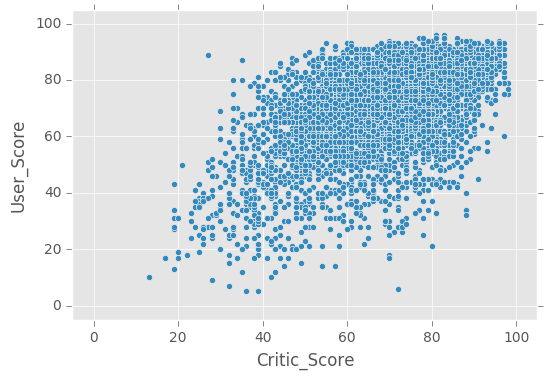

In [20]:
# Critic_Score and User_Score
short_dataset1.plot.scatter(x='Critic_Score', y='User_Score', xlim=(-5, 105), ylim=(-5,105))

In [21]:
"""
# Just for testing
groups = short_dataset1.groupby('Platform_Manufacturer')

# Plot
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)
ax.legend()

plt.show()
"""

"\n# Just for testing\ngroups = short_dataset1.groupby('Platform_Manufacturer')\n\n# Plot\nfig, ax = plt.subplots()\nfor name, group in groups:\n    ax.plot(group.Critic_Score, group.User_Score, marker='.', linestyle='', label=name)\nax.legend()\n\nplt.show()\n"

In [22]:
# TESTING: OUTLIER DETECTION
# We can't simply throw away just by a threshold, we gotta look at the data

# TODO: visual checks first!

OUTLIER_THRESHOLD = 1.5

# For each feature find the data points with extreme high or low values

# TODO: CHECK FOR MULTIPLE OUTLIERS

outliers = []

for feature in short_dataset1.keys():
    if short_dataset1[feature].dtype == float:

        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = short_dataset1[feature].quantile(0.25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = short_dataset1[feature].quantile(0.75)

        # Use the interquartile range to calculate an outlier step (OUTLIER_THRESHOLD times the interquartile range)
        step = (Q3 - Q1) * OUTLIER_THRESHOLD

        # Display the outlier count
        print "Data points considered outliers for the feature '{}': {}".format(feature, short_dataset1[~((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))].shape[0])
        outliers.extend(short_dataset1[~((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))].index.values)

        # remove outliers
        # short_dataset1 = short_dataset1[((short_dataset1[feature] >= Q1 - step) & (short_dataset1[feature] <= Q3 + step))]

display(short_dataset1.describe())
display(short_dataset1.head())

Data points considered outliers for the feature 'Year_of_Release': 0
Data points considered outliers for the feature 'NA_Sales': 688
Data points considered outliers for the feature 'EU_Sales': 747
Data points considered outliers for the feature 'JP_Sales': 1483
Data points considered outliers for the feature 'Other_Sales': 782
Data points considered outliers for the feature 'Global_Sales': 677
Data points considered outliers for the feature 'Critic_Score': 109
Data points considered outliers for the feature 'Critic_Count': 140
Data points considered outliers for the feature 'User_Score': 270
Data points considered outliers for the feature 'User_Count': 986


,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6862.000000,6862.000000,6862.000000,6862.000000,6862.000000,6862.000000,6862.000000,6862.000000,6862.000000,6862.000000
mean,2007.538618,0.388234,0.231284,0.059719,0.082034,0.761468,70.129991,29.048382,71.707374,172.046342
std,4.086787,0.958055,0.679564,0.273634,0.268882,1.937603,13.845684,19.216985,14.393680,582.215316
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,5.000000,4.000000
25%,2004.000000,0.060000,0.020000,0.000000,0.010000,0.110000,62.000000,14.000000,65.000000,11.000000
50%,2007.000000,0.150000,0.060000,0.000000,0.020000,0.290000,72.000000,25.000000,75.000000,27.000000
75%,2011.000000,0.390000,0.210000,0.010000,0.070000,0.740000,80.000000,40.000000,82.000000,87.000000
max,2016.000000,41.360000,28.960000,6.500000,10.570000,82.530000,98.000000,113.000000,96.000000,10665.000000


,Platform,Year_of_Release,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,82.53,76.0,51.0,80.0,322.0,E
2,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,35.52,82.0,73.0,83.0,709.0,E
3,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,32.77,80.0,73.0,80.0,192.0,E
6,DS,2006.0,Platform,11.28,9.14,6.50,2.88,29.80,89.0,65.0,85.0,431.0,E
7,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,28.92,58.0,41.0,66.0,129.0,E


In [24]:
# convert nominal features to boolean features
short_dataset1 = convertNominalFeatures(short_dataset1, ['Platform', 'Genre', 'Rating', 'Platform_Manufacturer'])

# separate features from target values
features, sales = separateTargetValues(short_dataset1)

In [25]:
# split data into training set and test set

# shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features, sales['Global'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Success
print "Training and testing split was successful."

Training and testing split was successful.


'----------'

Ridge(alpha=0.09, copy_X=True, fit_intercept=True, max_iter=1200,
   normalize=True, random_state=None, solver='auto', tol=0.001)

'The overall model has a coefficient of determination, R^2, of 0.1887.'

'----------'

LassoLars(alpha=0.1, copy_X=True, eps=2.2204460492503131e-16,
     fit_intercept=True, fit_path=True, max_iter=1200, normalize=False,
     positive=False, precompute='auto', verbose=False)

'The overall model has a coefficient of determination, R^2, of 0.1343.'

'=========='

0.18867457615318017

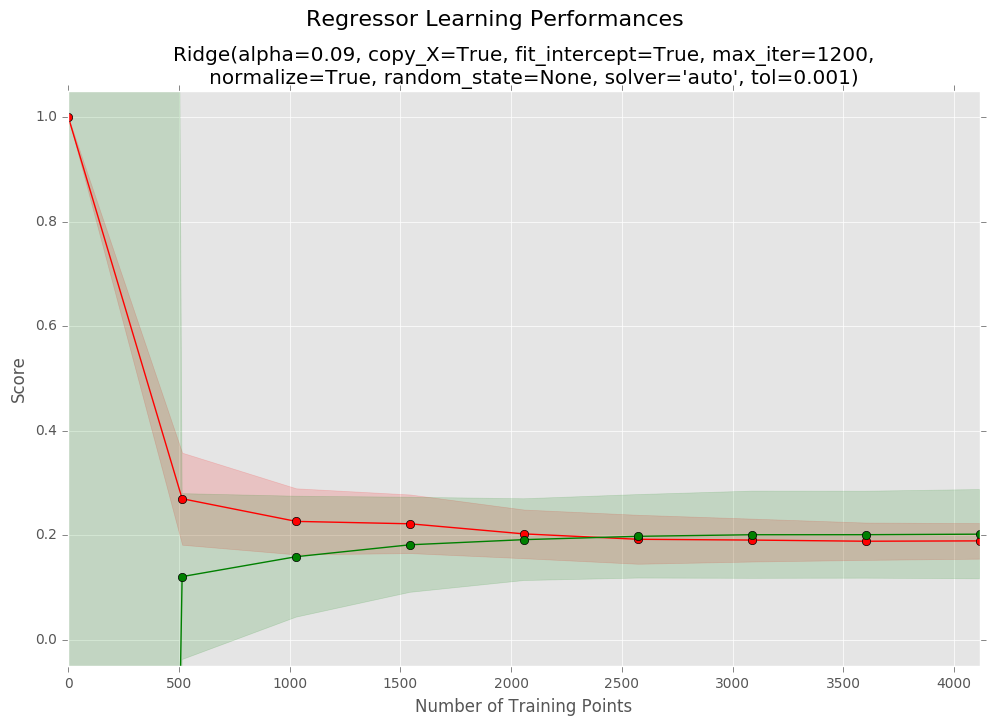

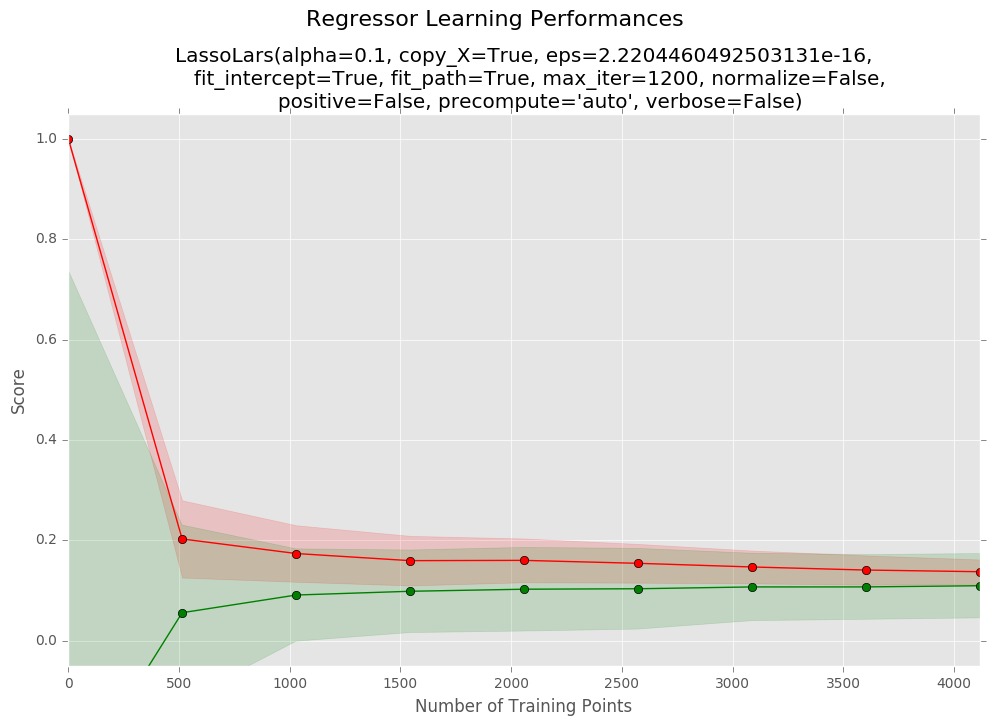

In [26]:
# http://scikit-learn.org/stable/tutorial/machine_learning_map/

regressors = [0, 1, 2]
reg_params = [0, 1, 2]
reg_score = [0, 1, 2]

# create a RidgeRegression regressor object (best: 0.1887)
regressor = Ridge()
params = {'alpha': [0.09, 0.1, 0.11],    # positve float
          'fit_intercept': [True, False], # boolean
          'max_iter': [1200],             # integer
          'normalize': [True, False],     # boolean
          'solver': ['auto'] # {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag'}
         }
regressors[0] = regressor
reg_params[0] = params

# create a LarsLasso regressor object
regressor = LassoLars()
params = {'alpha': [0.1, 0.27, 0.3, 0.33],
          'fit_intercept': [True, False],
          'positive': [True, False],
          'normalize': [True, False],
          'max_iter': [1200]
         }
regressors[1] = regressor
reg_params[1] = params
"""
# create a ElasticNet regressor object
regressor = ElasticNet()
params = {'alpha': [0.1, 0.27, 0.3, 0.33],
          'l1_ratio': [0, 0.1, 0.2, 0.3],
          'fit_intercept': [True, False],
          'normalize': [True, False],
          'max_iter' : [1200]
         }
regressors[2] = regressor
reg_params[2] = params

# create a decision tree regressor object
regressor = DecisionTreeRegressor()
params = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
regressors[3] = regressor
reg_params[3] = params
"""

"""
# takes too much time without clever proprocessing
# create a support vector regressor object
regressor = svm.SVR()
params = {'C': [0.07, 0.1, 0.3],
          'kernel': ['linear', 'rbf', 'poly'],
          'epsilon': [0.07, 0.1, 0.3],
          'degree': [2, 3, 7, 10]
         }
regressors[4] = regressor
reg_params[4] = params
"""

best_score = 0
for index in range(2):
# for index in range(len(regressors)):
    # Fit the training data to the model using grid search
    reg = fit_model(X_train, y_train, regressors[index], reg_params[index])
    vs.DisplayLearningCurve(X_train, y_train, reg, params)
    reg_score[index] = performance_metric(sales['Global'], reg.predict(features))
    display('----------')
    display(reg)
    display('The overall model has a coefficient of determination, R^2, of {:.4f}.'.format(reg_score[index]))
    best_score = (max(best_score, reg_score[index]))

display('==========')
display(best_score)